# VK Bot Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    average_precision_score,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    brier_score_loss,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
sns.set_theme(style='whitegrid', palette='husl')
print(f"Notebook started: {datetime.now():%Y-%m-%d %H:%M:%S}")

Notebook started: 2025-12-07 23:33:02


In [2]:
DATA_PATH = '../features_output/complete_features.csv'
df = pd.read_csv(DATA_PATH)
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (76862, 166)


,id,user_id,account_age_days,activity_per_day,reg_year,reg_month,reg_day_of_week,reg_hour,registered_night_hours,days_since_last_seen,last_seen_to_age_ratio,accounts_registered_same_day,first_name_cyrillic_ratio,last_name_cyrillic_ratio,name_mixed_alphabet,first_name_len,last_name_len,full_name_len,name_has_digits,text_fields_filled_count,profile_unique_words,profile_avg_text_length,photo_sizes_count,has_contact_info,verification_count,...,follower_sample_size,follower_network_density,avg_follower_similarity,follower_avg_out_degree,follower_median_out_degree,follower_zero_out_degree_rate,followers_suspicious_cluster,subscription_count,avg_group_popularity,median_group_popularity,group_type_entropy,avg_group_overlap,extreme_group_popularity,reply_out_degree,reply_in_degree,unique_interaction_partners,unique_repliers,reply_reciprocity_rate,post_owner_diversity,comments_per_post_owner,focused_commenting,low_engagement,local_clustering_coefficient,neighbor_count,suspicious_low_clustering
0,1,420254941,3169.0,0.055538,2017.0,3.0,3.0,0.0,0,59.352778,0.018729,11.0,0.0,0.0,0,4,6,10,0,0,0,0.0,4,1,0,...,3.0,0.0,1.0,1.0,1.0,0.0,1.0,5.0,3.2,2.0,0.0,2.2,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,89176,6853.0,0.057055,2007.0,2.0,1.0,0.0,0,59.323009,0.008657,1.0,0.0,0.0,0,5,7,12,0,0,0,0.0,4,1,0,...,3.0,0.0,1.0,1.0,1.0,0.0,1.0,5.0,29.6,23.0,0.0,28.6,0.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,3,107762,6844.0,0.043688,2007.0,3.0,3.0,0.0,0,59.412199,0.008681,1.0,0.0,0.0,0,6,11,17,0,2,64,257.0,4,1,0,...,3.0,0.0,1.0,1.0,1.0,0.0,1.0,5.0,27.0,2.0,0.0,26.0,0.0,1.0,0.0,1.0,0.0,0.000000,1.0,3.0,1.0,1.0,0.0,0.0,0.0
3,4,558746,6756.0,0.000000,2007.0,5.0,0.0,0.0,0,56.588970,0.000000,2.0,0.0,0.0,0,4,7,11,0,0,0,0.0,2,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,7.0,2.0,2.0,0.500000,1.0,8.0,1.0,0.0,0.0,0.0,0.0
4,5,804580,6729.0,0.006836,2007.0,6.0,6.0,0.0,0,59.320486,0.008816,6.0,0.0,0.0,0,5,7,12,0,5,19,22.8,4,1,0,...,3.0,0.0,1.0,1.0,1.0,0.0,1.0,5.0,180.6,102.0,0.0,179.6,0.0,1.0,7.0,1.0,7.0,0.142857,2.0,5.5,1.0,0.0,0.0,0.0,0.0


In [3]:
print('Target distribution:', df['target_is_bot'].value_counts())
print('Missing values (top 10):')
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False).head(10))
print('Numeric summary:')
df.describe().T.head(10)

Target distribution: target_is_bot
 0    70283
-1     4223
 1     2356
Name: count, dtype: int64
Missing values (top 10):
groups            76862
mutual_friends    76862
online_friends    76862
dtype: int64
Numeric summary:


,count,mean,std,min,25%,50%,75%,max
id,76862.0,3.843150e+04,2.218829e+04,1.000000,1.921625e+04,3.843150e+04,5.764675e+04,7.686200e+04
user_id,76862.0,4.791368e+08,3.201618e+08,7123.000000,1.779031e+08,4.772697e+08,7.545974e+08,1.084750e+09
account_age_days,76862.0,3.154915e+03,1.928114e+03,57.000000,1.360000e+03,3.024000e+03,4.882000e+03,6.920000e+03
activity_per_day,76862.0,2.238094e-02,2.488243e-01,0.000000,0.000000e+00,0.000000e+00,1.325718e-02,3.703284e+01
reg_year,76862.0,2.016763e+03,5.288104e+00,2006.000000,2.012000e+03,2.017000e+03,2.022000e+03,2.025000e+03
reg_month,76862.0,6.459746e+00,3.438295e+00,1.000000,3.000000e+00,7.000000e+00,9.000000e+00,1.200000e+01
reg_day_of_week,76862.0,3.021896e+00,1.953101e+00,0.000000,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00
reg_hour,76862.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
registered_night_hours,76862.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
days_since_last_seen,76862.0,5.552300e+01,4.787423e+01,2.181748,5.658897e+01,5.658897e+01,5.658897e+01,2.907306e+03


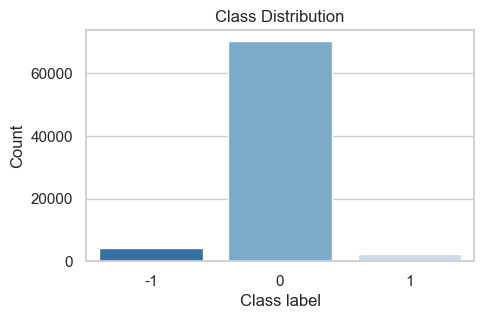

In [4]:
plt.figure(figsize=(5,3))
class_counts = df['target_is_bot'].value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values, palette='Blues_r')
plt.title('Class Distribution')
plt.xlabel('Class label')
plt.ylabel('Count')
plt.show()

## Hold out

In [5]:
feature_cols = [c for c in df.columns if c not in ['id', 'user_id', 'target_is_bot']]

df_labeled = df[df['target_is_bot'] != -1].copy()
df_unlabeled = df[df['target_is_bot'] == -1].copy()

X = df_labeled[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
y = df_labeled['target_is_bot'].astype(int)

X_unlabeled = df_unlabeled[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Labeled samples: {len(df_labeled):,}')
print(f'Positive rate: {y.mean()*100:.2f}%')
print(f'Train shape: {X_train.shape}, Validation shape: {X_val.shape}')
imbalance_ratio = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
print(f'Imbalance ratio (majority/minority): {imbalance_ratio:.1f}:1')

Labeled samples: 72,639
Positive rate: 3.24%
Train shape: (58111, 163), Validation shape: (14528, 163)
Imbalance ratio (majority/minority): 29.8:1


## Correlation

In [6]:
corr = X.assign(target=y).corr(method='spearman')['target'].drop('target')
correlated = corr.abs().sort_values(ascending=False)
top_corr = correlated.head(20)

top_corr.to_frame('spearman_abs').style.background_gradient(cmap='Reds')

,spearman_abs
avg_comment_length,0.227192
avg_words_per_comment,0.224719
avg_sentence_length,0.217542
avg_text_entropy,0.211339
post_owner_diversity,0.199287
total_chars,0.175426
vocab_size,0.173903
total_words,0.172826
reg_year,0.171264
account_age_days,0.167892


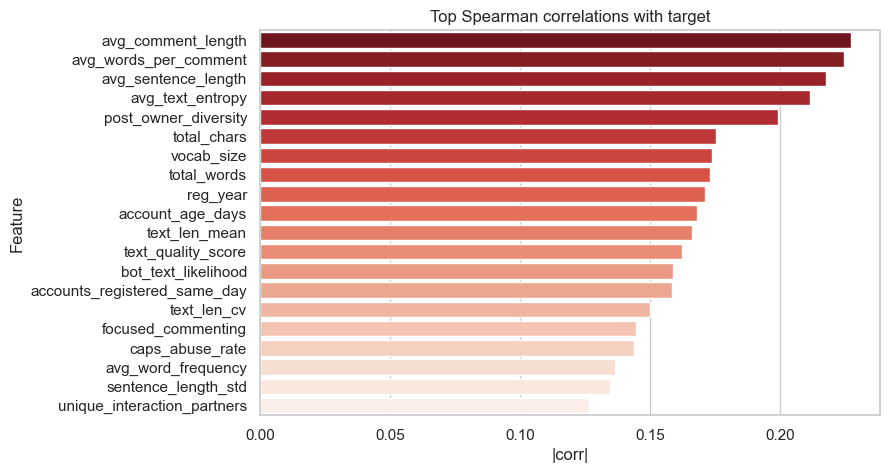

In [7]:
plt.figure(figsize=(8,5))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='Reds_r')
plt.title('Top Spearman correlations with target')
plt.xlabel('|corr|')
plt.ylabel('Feature')
plt.show()

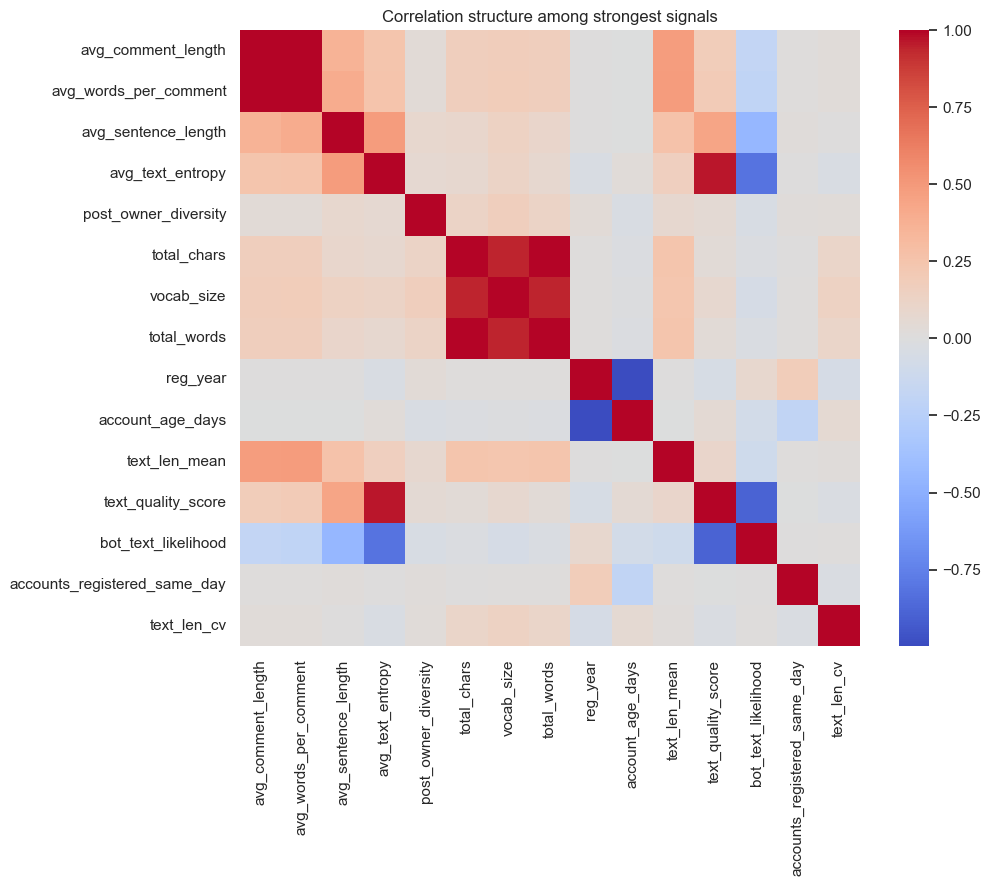

In [8]:
plt.figure(figsize=(10,8))
heatmap_cols = top_corr.index[:15]
sns.heatmap(X[heatmap_cols].corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Correlation structure among strongest signals')
plt.show()

## Models preparing 

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}

pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            max_iter=2000,
            class_weight='balanced',
            solver='liblinear'
        ))
    ]),
    'RandomForest': RandomForestClassifier(
        n_estimators=400,
        max_depth=18,
        min_samples_split=4,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
    ),
    'GradientBoosting': GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=400,
        max_depth=3,
        random_state=42
    ),
    'LightGBM': LGBMClassifier(
        objective='binary',
        class_weight='balanced',
        n_estimators=600,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.7,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    ),
    'XGBoost': XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',
        max_depth=6,
        learning_rate=0.05,
        n_estimators=700,
        subsample=0.8,
        colsample_bytree=0.6,
        scale_pos_weight=pos_weight,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ),
    'CatBoost': CatBoostClassifier(
        iterations=700,
        depth=8,
        learning_rate=0.05,
        random_state=42,
        verbose=False,
        auto_class_weights='Balanced'
    ),
    'LinearSVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', CalibratedClassifierCV(
            estimator=LinearSVC(
                class_weight='balanced',
                dual=False,
                max_iter=5000,
                random_state=42
            ),
            cv=3,
            method='sigmoid'
        ))
    ]),
}

print('Models prepared:', ', '.join(models.keys()))

Models prepared: LogisticRegression, RandomForest, GradientBoosting, LightGBM, XGBoost, CatBoost, LinearSVM


## Cross-validated Benchmarks

In [10]:
baseline_rows = []
for name, model in models.items():
    scores = cross_validate(
        model,
        X_train,
        y_train,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=False
    )
    baseline_rows.append({
        'model': name,
        'precision': scores['test_precision'].mean(),
        'recall': scores['test_recall'].mean(),
        'f1': scores['test_f1'].mean(),
        'roc_auc': scores['test_roc_auc'].mean(),
        'accuracy': scores['test_accuracy'].mean(),
    })

baseline_df = pd.DataFrame(baseline_rows).sort_values('roc_auc', ascending=False)
baseline_df.reset_index(drop=True)

,model,precision,recall,f1,roc_auc,accuracy
0,LightGBM,0.725862,0.786207,0.754722,0.969024,0.983428
1,XGBoost,0.741154,0.784615,0.762103,0.968926,0.984117
2,CatBoost,0.688756,0.798939,0.739606,0.968784,0.981759
3,GradientBoosting,0.857957,0.619098,0.719033,0.965274,0.984323
4,RandomForest,0.616032,0.720955,0.664215,0.960935,0.976356
5,LinearSVM,0.772839,0.396286,0.523050,0.952282,0.976614
6,LogisticRegression,0.235720,0.892838,0.372970,0.951606,0.902617


## Hyperparameter Tuning 

In [11]:
top_models = baseline_df.head(3)['model'].tolist()
print('Top models:', top_models)

lgbm_param_dist = {
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 12, 18],
    'learning_rate': [0.03, 0.05, 0.08],
    'n_estimators': [600, 800, 1000],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
}

cat_param_dist = {
    'depth': [6, 8, 10],
    'learning_rate': [0.03, 0.05, 0.08],
    'iterations': [800, 1000, 1200],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [64, 128],
}

xgb_param_dist = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.08],
    'n_estimators': [600, 900, 1100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'reg_lambda': [0.5, 1.0, 1.5],
}

searches = {}

if 'LightGBM' in top_models:
    lgbm = LGBMClassifier(
        objective='binary',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )
    lgbm_search = RandomizedSearchCV(
        lgbm,
        lgbm_param_dist,
        n_iter=20,
        scoring='roc_auc',
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    lgbm_search.fit(X_train, y_train)
    searches['LightGBM'] = lgbm_search
    print('Best LightGBM params:', lgbm_search.best_params_)

if 'CatBoost' in top_models:
    cat = CatBoostClassifier(
        random_state=42,
        verbose=False,
        auto_class_weights='Balanced'
    )
    cat_search = RandomizedSearchCV(
        cat,
        cat_param_dist,
        n_iter=15,
        scoring='roc_auc',
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    cat_search.fit(X_train, y_train)
    searches['CatBoost'] = cat_search
    print('Best CatBoost params:', cat_search.best_params_)

if 'XGBoost' in top_models:
    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',
        scale_pos_weight=pos_weight,
        random_state=42,
        n_jobs=-1
    )
    xgb_search = RandomizedSearchCV(
        xgb,
        xgb_param_dist,
        n_iter=15,
        scoring='roc_auc',
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    xgb_search.fit(X_train, y_train)
    searches['XGBoost'] = xgb_search
    print('Best XGBoost params:', xgb_search.best_params_)

Top models: ['LightGBM', 'XGBoost', 'CatBoost']
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best LightGBM params: {'subsample': 0.7, 'num_leaves': 127, 'n_estimators': 600, 'max_depth': 12, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best CatBoost params: {'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 1200, 'depth': 6, 'border_count': 128}
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best XGBoost params: {'subsample': 0.6, 'reg_lambda': 0.5, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


## Hold-out Evaluation

In [12]:
def evaluate_holdout(model, name):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    metrics = {
        'model': name,
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'roc_auc': roc_auc_score(y_val, y_proba),
        'accuracy': accuracy_score(y_val, y_pred),
        'average_precision': average_precision_score(y_val, y_proba),
    }
    return metrics, y_pred, y_proba

holdout_rows = []
proba_cache = {}

for name, search in searches.items():
    best_model = search.best_estimator_
    best_model.fit(X_train, y_train)
    metrics, preds, probas = evaluate_holdout(best_model, name)
    holdout_rows.append(metrics)
    proba_cache[name] = probas

holdout_df = pd.DataFrame(holdout_rows).sort_values('roc_auc', ascending=False)
holdout_df

,model,precision,recall,f1,roc_auc,accuracy,average_precision
2,XGBoost,0.449162,0.853503,0.588580,0.960969,0.961316,0.800008
0,LightGBM,0.790323,0.728238,0.758011,0.960472,0.984926,0.817293
1,CatBoost,0.505792,0.834395,0.629808,0.960253,0.968199,0.806828


Best hold-out model: XGBoost


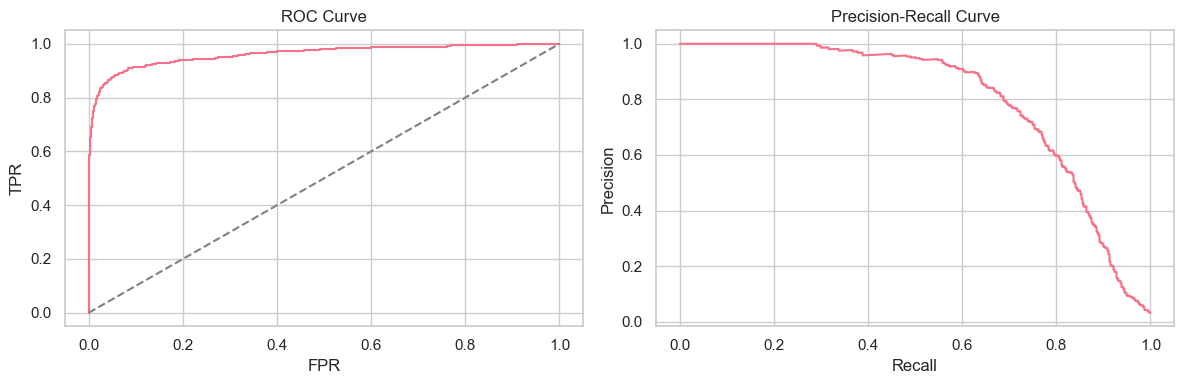

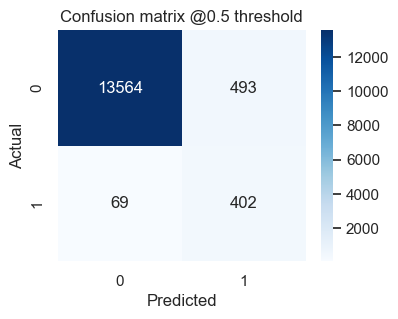

In [13]:
best_name = holdout_df.iloc[0]['model']
best_proba = proba_cache[best_name]
print(f'Best hold-out model: {best_name}')

fpr, tpr, _ = roc_curve(y_val, best_proba)
prec, rec, _ = precision_recall_curve(y_val, best_proba)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--',color='gray')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.subplot(1,2,2)
plt.plot(rec, prec)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_val, (best_proba >= 0.5).astype(int))
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix @0.5 threshold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Probability Calibration and Threshold Search

In [14]:
base_model = searches[best_name].best_estimator_
calibrated = CalibratedClassifierCV(estimator=base_model, cv=5, method='sigmoid')
calibrated.fit(X_train, y_train)
cal_proba = calibrated.predict_proba(X_val)[:, 1]

brier = brier_score_loss(y_val, cal_proba)
print(f'Brier score (lower is better): {brier:.4f}')

Brier score (lower is better): 0.0134


In [15]:
def threshold_grid(proba, y_true, grid=None):
    grid = grid if grid is not None else np.linspace(0.05, 0.95, 50)
    rows = []
    for thr in grid:
        preds = (proba >= thr).astype(int)
        rows.append({
            'threshold': thr,
            'precision': precision_score(y_true, preds, zero_division=0),
            'recall': recall_score(y_true, preds),
            'accuracy': accuracy_score(y_true, preds),
            'f1': f1_score(y_true, preds),
        })
    return pd.DataFrame(rows)

threshold_df = threshold_grid(cal_proba, y_val)
threshold_df.sort_values('f1', ascending=False).head(10)

,threshold,precision,recall,accuracy,f1
34,0.674490,0.863128,0.656051,0.985476,0.745476
32,0.637755,0.826425,0.677282,0.984926,0.744457
26,0.527551,0.760532,0.728238,0.983756,0.744035
22,0.454082,0.731959,0.753715,0.983067,0.742678
33,0.656122,0.841398,0.664544,0.985063,0.742586
24,0.490816,0.744136,0.740977,0.983343,0.742553
31,0.619388,0.816327,0.679406,0.984650,0.741599
27,0.545918,0.769406,0.715499,0.983824,0.741474
30,0.601020,0.805486,0.685775,0.984444,0.740826
28,0.564286,0.778037,0.707006,0.983962,0.740823


In [16]:
best_f1_row = threshold_df.sort_values('f1', ascending=False).iloc[0]
best_precision_row = threshold_df.sort_values(['precision','recall'], ascending=False).iloc[0]

print('Best F1 threshold:', best_f1_row.to_dict())
print('Best precision-driven threshold:', best_precision_row.to_dict())

optimal_threshold = best_f1_row['threshold']
final_preds = (cal_proba >= optimal_threshold).astype(int)

print('Metrics optimal threshold')
print('Precision:', precision_score(y_val, final_preds))
print('Recall   :', recall_score(y_val, final_preds))
print('F1       :', f1_score(y_val, final_preds))
print('Accuracy :', accuracy_score(y_val, final_preds))
print('ROC-AUC  :', roc_auc_score(y_val, cal_proba))

Best F1 threshold: {'threshold': 0.6744897959183673, 'precision': 0.8631284916201117, 'recall': 0.6560509554140127, 'accuracy': 0.985476321585903, 'f1': 0.7454764776839565}
Best precision-driven threshold: {'threshold': 0.7663265306122449, 'precision': 0.9719101123595506, 'recall': 0.3673036093418259, 'accuracy': 0.9791437224669604, 'f1': 0.5331278890600925}
Metrics optimal threshold
Precision: 0.8631284916201117
Recall   : 0.6560509554140127
F1       : 0.7454764776839565
Accuracy : 0.985476321585903
ROC-AUC  : 0.9604487160026504


## Feature Importance

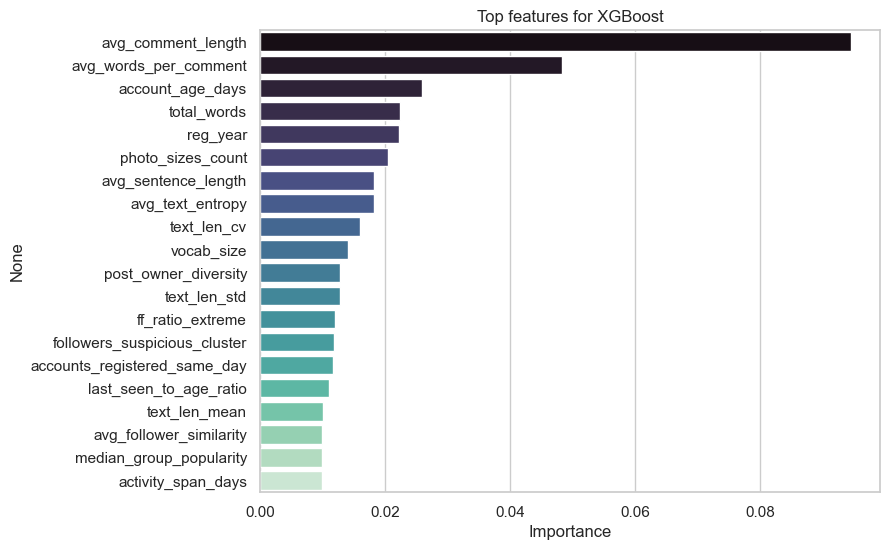

In [17]:
if hasattr(base_model, 'feature_importances_'):
    importances = pd.Series(base_model.feature_importances_, index=feature_cols)
    top_importances = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=top_importances.values, y=top_importances.index, palette='mako')
    plt.title(f'Top features for {best_name}')
    plt.xlabel('Importance')
    plt.show()
    top_importances.to_frame('importance')

## Score Unlabeled Accounts

In [18]:
if not df_unlabeled.empty:
    unlabeled_proba = calibrated.predict_proba(X_unlabeled)[:, 1]
    df_unlabeled = df_unlabeled.copy()
    df_unlabeled['bot_probability'] = unlabeled_proba
    df_unlabeled['predicted_bot'] = (unlabeled_proba >= optimal_threshold).astype(int)
    output_cols = ['id', 'user_id', 'bot_probability', 'predicted_bot']
    df_unlabeled[output_cols].to_csv('predictions_calibrated.csv', index=False)
    print('Saved predictions_calibrated.csv with', len(df_unlabeled), 'rows')
    df_unlabeled.sort_values('bot_probability', ascending=False).head(10)

Saved predictions_calibrated.csv with 4223 rows
